# Causal Inference in Python
Original author https://github.com/rugg2
Adapted by gtb950

This notebook is an exploration of causal inference in python using the famous Lalonde dataset.
* Causal inference is a technique to estimate the effect of one variable onto another, given the presence of other influencing variables (confonding factors) that we try to keep 'controlled'.

The study looked at the effectiveness of a job training program (the treatment) on the real earnings of an individual, a couple years after completion of the program.

The data consists of a number of demographic variables (age, race, academic background, and previous real earnings), as well as a treatment indicator, and the real earnings in the year 1978 (the response).

*Robert Lalonde, "Evaluating the Econometric Evaluations of Training Programs", American Economic Review, Vol. 76, pp. 604-620*

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In this notebook we'll be using the tools provided by Laurence Wong in the Package *CausalInference*. Comments on what each function does come from the very good package documentation: http://laurence-wong.com/software/

This package relies heavily on Rubin causal model, and so will this analysis https://en.wikipedia.org/wiki/Rubin_causal_model

The reason why several models exist is that it is impossible to observe the causal effect on a single unit, and so assumptions must be made to estimate the missing counterfactuals. We'll explain what all that means in this post.

In [5]:
# https://pypi.org/project/CausalInference/
from causalinference import CausalModel

In [6]:
url = 'https://raw.githubusercontent.com/rugg2/rugg2.github.io/refs/heads/master/lalonde.csv'
lalonde = pd.read_csv(url,index_col=0,parse_dates=[0])
lalonde.head()

C:\Users\dnedi\AppData\Local\Temp\ipykernel_3944\2584875479.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  lalonde = pd.read_csv(url,index_col=0,parse_dates=[0])
C:\Users\dnedi\AppData\Local\Temp\ipykernel_3944\2584875479.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  lalonde = pd.read_csv(url,index_col=0,parse_dates=[0])


,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [7]:
# let's have an overview of the data
lalonde.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


**Here is the *raw* difference in earning between the control group and the treated group:**

In [8]:
lalonde.groupby('treat')['re78'].agg(['median','mean'])

,median,mean
treat,,
0,4975.505,6984.169742
1,4232.309,6349.143530


The control group has higher earning that the treatment group - does this mean the treatment had a negative impact?

treat
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
Name: re78, dtype: object

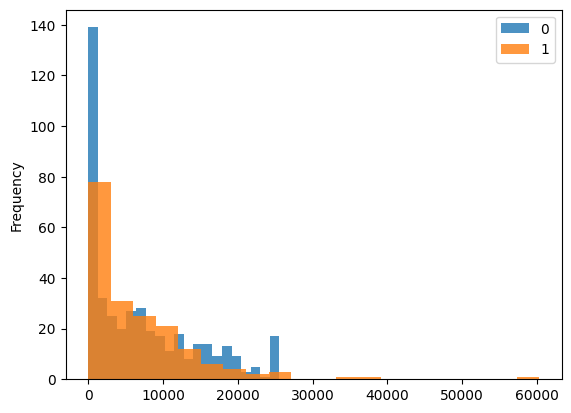

In [9]:
lalonde.groupby('treat')['re78'].plot(kind='hist', bins=20, alpha=0.8, legend=True)

**This dataset is not a balanced trial.** Indeed people in the control group are very different from people in the test (treatment) group. Below is a plot of the different income distributions:

treat
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
Name: re74, dtype: object

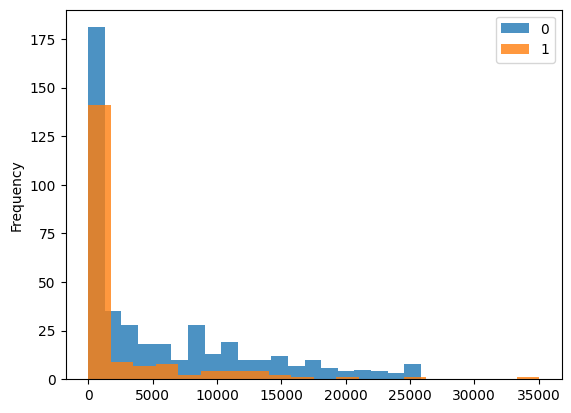

In [10]:
lalonde.groupby('treat')['re74'].plot(kind='hist', bins=20, alpha=0.8, legend=True)

treat
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
Name: age, dtype: object

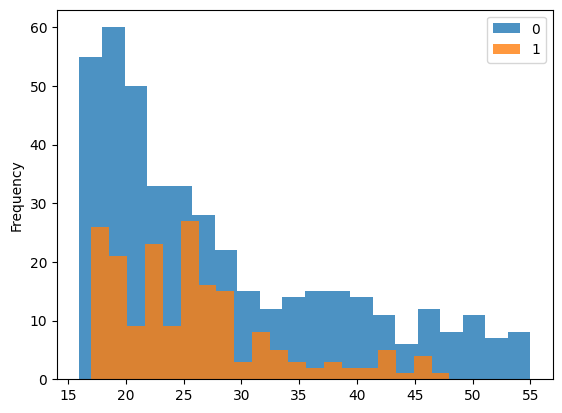

In [11]:
lalonde.groupby('treat')['age'].plot(kind='hist', bins=20, alpha=0.8, legend=True)

treat
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
Name: educ, dtype: object

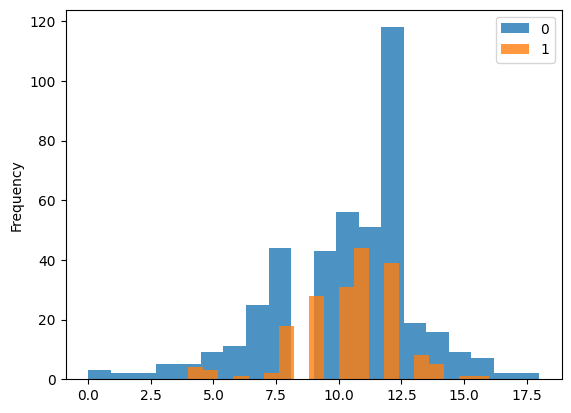

In [12]:
lalonde.groupby('treat')['educ'].plot(kind='hist', bins=20, alpha=0.8, legend=True)

## Example causal-learn

In [17]:
import numpy as np
import pandas as pd
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
import pydot
from IPython.display import display, Image
from causalinference import CausalModel


data_for_pc = lalonde[['treat', 'age', 'educ', 're74', 're75', 're78']]


data_np = data_for_pc.to_numpy()
print(data_for_pc)

cg = pc(data_np, alpha=0.05, indep_test='fisherz')


labels = ['treat', 'age', 'educ', 're74', 're75', 're78']
pyd = GraphUtils.to_pydot(cg.G, labels=labels)
display(Image(pyd.create_png()))

#
# # Causal Inference using CausalModel
# Y = lalonde['re78'].values
# D = lalonde['treat'].values
# X = lalonde[['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']].values
#
# causal = CausalModel(Y, D, X)
# causal.est_via_ols()
# causal.estimates


         treat  age  educ  re74  re75        re78
NSW1         1   37    11   0.0   0.0   9930.0460
NSW2         1   22     9   0.0   0.0   3595.8940
NSW3         1   30    12   0.0   0.0  24909.4500
NSW4         1   27    11   0.0   0.0   7506.1460
NSW5         1   33     8   0.0   0.0    289.7899
...        ...  ...   ...   ...   ...         ...
PSID425      0   18    11   0.0   0.0  10150.5000
PSID426      0   24     1   0.0   0.0  19464.6100
PSID427      0   21    18   0.0   0.0      0.0000
PSID428      0   32     5   0.0   0.0    187.6713
PSID429      0   16     9   0.0   0.0   1495.4590

[614 rows x 6 columns]


  0%|          | 0/6 [00:00<?, ?it/s]

FileNotFoundError: [WinError 2] "dot" not found in path.

In [ ]:
## Example DoDiscover

In [ ]:
from causal_ai.models.tabular.pc import PC
import numpy as np


# Initialize and fit
model = PC()
model.fit(lalonde)

# Get adjacency matrix
print(model.adjacency_matrix)